# Classification Models

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve, precision_score, classification_report
from sklearn.inspection import permutation_importance

## Import data

In [2]:
# Import data
contracts = pd.read_csv('../../data/contracts_with_new_data_MEAN.csv')

C:\Users\franc\AppData\Local\Temp\ipykernel_18916\1631020948.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  contracts = pd.read_csv('../../data/contracts_with_new_data_MEAN.csv')


## Preparation

In [3]:
# Clean data that is not needed for the model
contracts = contracts.drop(['Unnamed: 0', 'SF-SYSTEM', 'ANO_SID', 'ORTS-NAME', 'STRASSE', 'PARTY-ID', 'contract_year'], axis=1)
contracts = contracts.dropna()

In [4]:
# Compute percentage of contracts with a damage
one = contracts['DAMAGE'][contracts['DAMAGE']==1].sum()
length = len(contracts)
print(length, one, one/length)

7792683 112491 0.014435464653188125


In [91]:
contracts['CORPORATE_DEVISION'].unique()

array(['VHV', 'VGV'], dtype=object)

In [92]:
# Create subset for each corporate devision
vhv = contracts[contracts['CORPORATE_DEVISION']=='VHV']
vgv = contracts[contracts['CORPORATE_DEVISION']=='VGV']
ww = contracts[contracts['CORPORATE_DEVISION']=='W&W']
hh = contracts[contracts['CORPORATE_DEVISION']=='H&H']
print('vhv: ', len(vhv))
print('vgv: ', len(vgv))
print('ww: ', len(ww))
print('hh: ', len(hh))

vhv:  5793931
vgv:  1998752
ww:  0
hh:  0


In [93]:
# Compute percentage of contracts with a damage
one = vhv['DAMAGE'][vhv['DAMAGE']==1].sum()
length = len(vhv)
print('vhv: ', one/length)

one = vgv['DAMAGE'][vgv['DAMAGE']==1].sum()
length = len(vgv)
print('vgv: ', one/length)

one = ww['DAMAGE'][ww['DAMAGE']==1].sum()
length = len(ww)
print('ww: ', one/length)

one = hh['DAMAGE'][hh['DAMAGE']==1].sum()
length = len(hh)
print('hh: ', one/length)

vhv:  0.0038795767502236393
vgv:  0.04503460159139303
ww:  nan
hh:  nan


C:\Users\franc\AppData\Local\Temp\ipykernel_476\990885517.py:12: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\franc\AppData\Local\Temp\ipykernel_476\990885517.py:16: RuntimeWarning:

invalid value encountered in scalar divide



In [94]:
# Drop nas and empty columns, so that the dataset is usable in the models.
vhv = vhv.dropna()
vgv = vgv.dropna()
ww = ww.drop(['CONSTRACTION_DESIGN', 'PRODUCTLINE'], axis=1)
hh = hh.drop(['CONSTRACTION_DESIGN', 'PRODUCTLINE'], axis=1)

In [17]:
# Pick dataset for the analysis
df = contracts.copy()

In [18]:
# Prepare binary variables
columns_to_encode = ['CORPORATE_DEVISION','CONSTRACTION_DESIGN', 'PRODUCTLINE', 'UNDERWRITER', 'ZONE']
df_binary = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

In [21]:
# Training data: 2014; testing data: 2015

# subsets
# train = df_binary[df_binary['YEAR']==2014].sample(frac=0.1, random_state=1234)
# test = df_binary[df_binary['YEAR']==2015].sample(frac=0.1, random_state=1234)

# full data
train = df_binary[df_binary['YEAR']==2014]
test = df_binary[df_binary['YEAR']==2015]

# Separate features and target variable
X_train = train.drop(['YEAR', 'DAMAGE'], axis=1)
y_train = train['DAMAGE']

X_test = test.drop(['YEAR', 'DAMAGE'], axis=1)
y_test = test['DAMAGE']

In [14]:
# Apply undersampling (instead of SMOTE)
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

In [22]:
# Apply SMOTE (instead of undersampling)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## K-nearest neighbours

### Hyperparameter tuning

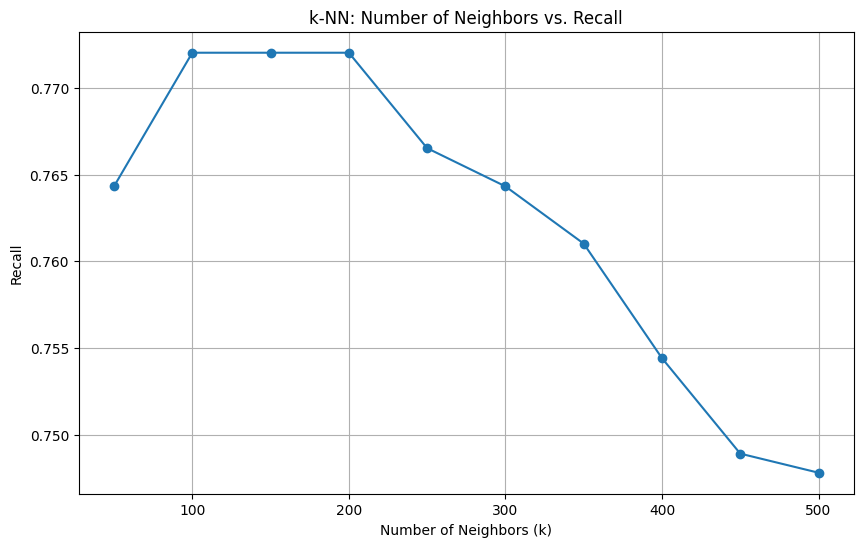

In [101]:
# Initialize lists to store recall scores for different k
k_values = range(50, 501, 50)
recall_scores = []

# Loop over different values of k
for k in k_values:
    # Initialize model
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    # Train the model with resampled training data
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred, average='binary')
    recall_scores.append(recall)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Recall')
plt.title('k-NN: Number of Neighbors vs. Recall')
plt.grid()
plt.show()

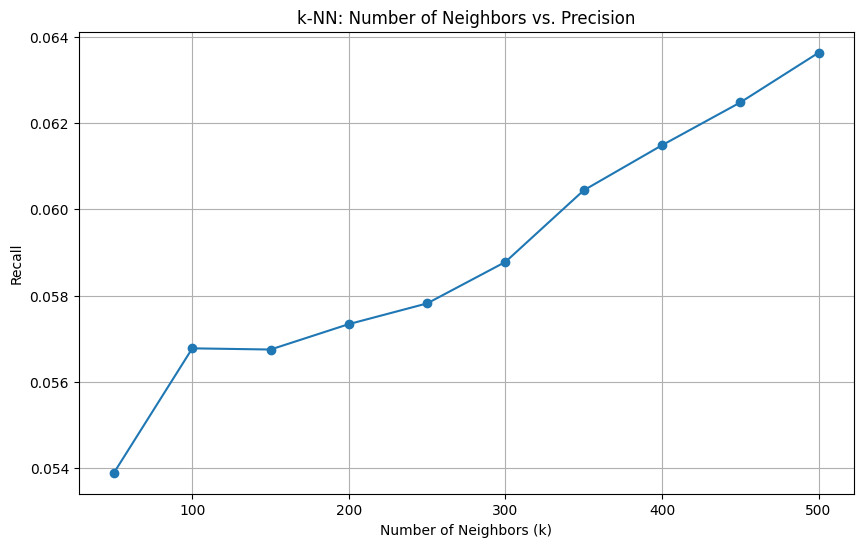

In [102]:
# Initialize lists to store precision scores for different k
k_values = range(50, 501, 50)
precision_scores = []

# Loop over different values of k
for k in k_values:
    # Initialize model
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    # Train the model with resampled training data
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate recall
    precision = precision_score(y_test, y_pred, average='binary')
    precision_scores.append(precision)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Recall')
plt.title('k-NN: Number of Neighbors vs. Precision')
plt.grid()
plt.show()

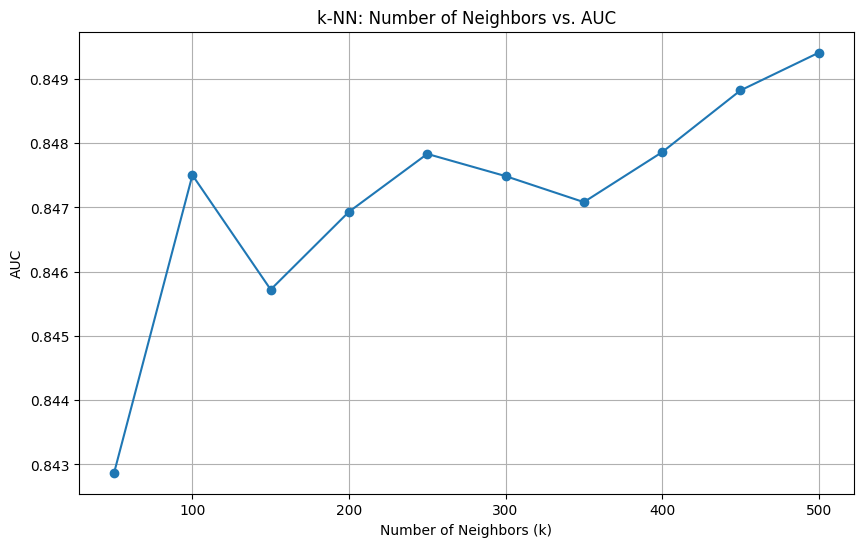

In [103]:
# Initialize lists to store AUC scores for different k
k_values = range(50, 501, 50)
auc_scores = []

# Loop over different values of k
for k in k_values:
    # Initialize model
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    # Train the model with resampled training data
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, auc_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC')
plt.title('k-NN: Number of Neighbors vs. AUC')
plt.grid()
plt.show()

### Model and evaluation

We are interested in the recall. We want to reduce the false negative, as these are contracts predicted as non-risky, which in reality present a risk.

Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

High recall means that most of the actual positive cases are captured by the model, even if it means including some false positives.

Recall = TP / (TP + FN)

In [23]:
# Initialize model
KNNmodel = KNeighborsClassifier(n_neighbors=100, weights='distance')

In [24]:
# Train the model
KNNmodel.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = KNNmodel.predict(X_test) # binary prediction
y_pred_proba = KNNmodel.predict_proba(X_test)[:, 1] # probability prediction

# Set boundary for probability
threshold = 0.8
y_pred_custom = (y_pred_proba >= threshold).astype(int) # custom binary prediction

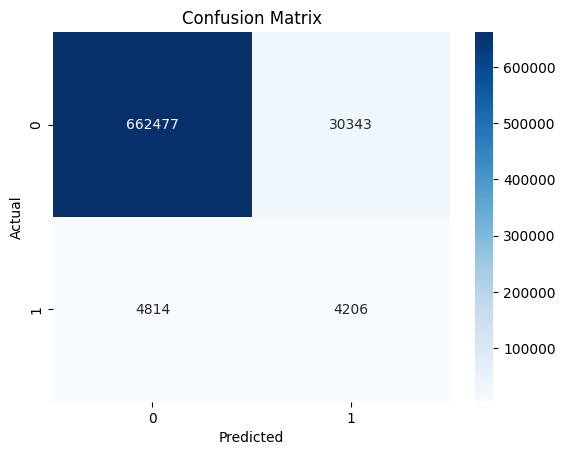

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# Classification report
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    692820
           1       0.12      0.47      0.19      9020

    accuracy                           0.95    701840
   macro avg       0.56      0.71      0.58    701840
weighted avg       0.98      0.95      0.96    701840



In [27]:
# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.800311224504165


In [28]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create a DataFrame for Plotly
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Plot ROC curve
fig = px.area(
    roc_data, 
    x='False Positive Rate', 
    y='True Positive Rate', 
    title=f'ROC Curve KNN (AUC = {auc:.2f})',
    width=700, 
    height=500
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, linecolor='black'),
    paper_bgcolor='white'
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.show()

In [30]:
# Feature importance
perm_importance = permutation_importance(KNNmodel, X_test, y_test, n_repeats=10, random_state=1234)
feature_names = [col for col in df.columns if col not in ['DAMAGE', 'YEAR']]
importance_df = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(importance_df)

                                               Importance
SUM_INSURED                                      0.013666
UNDERWRITER_Y                                    0.000000
ZONE_2                                           0.000000
ZONE_2.0                                         0.000000
ZONE_3.0                                         0.000000
ZONE_4.0                                         0.000000
ZONE_5.0                                         0.000000
ZONE_6.0                                         0.000000
ZONE_7.0                                         0.000000
ZONE_8.0                                         0.000000
ZONE_0                                           0.000000
ZONE_0.0                                         0.000000
ZONE_1                                           0.000000
ZONE_1.0                                         0.000000
ZONE_2.0                                         0.000000
ZONE_3                                           0.000000
ZONE_3.0      

We tried excluding the variables with a negative feature importance, but this didn't improve the model performance.

### KNN on 10 years

In [29]:
df = df.sort_values(by='YEAR').reset_index(drop=True) # Sort dataframe by year

# Prepare binary variables
columns_to_encode = ['CORPORATE_DEVISION','CONSTRACTION_DESIGN', 'PRODUCTLINE', 'UNDERWRITER', 'ZONE']
df_binary = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

years = range(2014, 2024)
smote = SMOTE(random_state=42) # SMOTE

results = []
all_y_pred = []

for year in tqdm(years, desc="Processing years"):
    # Prepare training and test datasets
    train = df_binary[df_binary['YEAR'] == year]
    test = df_binary[df_binary['YEAR'] == year + 1]

    X_train = train.drop(['YEAR', 'DAMAGE'], axis=1)
    y_train = train['DAMAGE']
    X_test = test.drop(['YEAR', 'DAMAGE'], axis=1)
    y_test = test['DAMAGE']

    # Perform resampling
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize model
    KNNmodel = KNeighborsClassifier(n_neighbors=100, weights='distance')

    # Run the model
    KNNmodel.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred_proba = KNNmodel.predict_proba(X_test)[:, 1] # probability prediction
    threshold = 0.8
    y_pred_custom = (y_pred_proba >= threshold).astype(int) # custom binary prediction

    # Compute performance
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom, average='binary')
    precision = precision_score(y_test, y_pred_custom, average='binary')
    results.append({'year': year, 'auc': auc, 'accuracy': accuracy, 'recall': recall, 'precision': precision})

    # Collect all predicted values
    all_y_pred.extend(y_pred_custom)

# Create dataframe with performance indicators
results_df = pd.DataFrame(results)

# Confusion matrix for the entire dataset
conf_matrix = confusion_matrix(df[df['YEAR'] != 2014]['DAMAGE'], all_y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Add predictions to the dataset
df.loc[df['YEAR'] != 2014, 'PREDICTIONS'] = all_y_pred
print('Predictions added!')

# Add observation type to the dataset
df['OBSERVATION_TYPE'] = np.where((df['DAMAGE'] == 1) & (df['PREDICTIONS'] == 1), 'tp',
                                   np.where((df['DAMAGE'] == 0) & (df['PREDICTIONS'] == 0), 'tn',
                                            np.where((df['DAMAGE'] == 1) & (df['PREDICTIONS'] == 0), 'fn',
                                                     np.where((df['DAMAGE'] == 0) & (df['PREDICTIONS'] == 1), 'fp', np.nan))))
print('Observation type added!')

# Save csv file
df.to_csv('../../knn_data/knn_results_all.csv', index=False)
print('Finished!')

Processing years: 100%|██████████| 10/10 [1:59:11<00:00, 715.19s/it]


Confusion Matrix:
 [[6685682  330604]
 [  64854   38441]]
Predictions added!
Observation type added!
Finished!


In [30]:
# Transform dataframe to long format
results_df_long = results_df.melt(id_vars='year', value_vars=['auc', 'accuracy', 'recall', 'precision'],
                                  var_name='metric', value_name='value')

In [31]:
# Plot results
fig = px.line(results_df_long, x='year', y='value', color='metric', 
              title='Yearly KNN Model Performance')

fig.update_layout(
    xaxis=dict(showgrid=False, linecolor='black'),
    yaxis=dict(showgrid=False, linecolor='black', zeroline= False),
    paper_bgcolor='white'
)

fig.show()

In [32]:
mean_metrics = results_df[['auc', 'accuracy', 'recall', 'precision']].mean().reset_index()
mean_metrics.columns = ['Metric', 'Mean']
print(mean_metrics)

      Metric      Mean
0        auc  0.765953
1   accuracy  0.944510
2     recall  0.365178
3  precision  0.103324


Parameters:
- n_neighbors = 100 (trade-off tuning and computing power)
- weights = distance better when data is not uniform and on different scales
- algorithm = ball_tree better for larger datasets and flexible in handling various types of data distributions
- metric = manhattan better for mixed data types
- In practice no significant difference in the performance of the models

Results:

| Dataset | AUC    | Accuracy | Recall | Precision |
|---------|--------|----------|--------|-----------|
| VHV     | 0.5343 | 0.4824   | 0.5681 | 0.0040    |
| VGV     | 0.7006 | 0.7153   | 0.5687 | 0.0874    |
| WW      | 0.5696 | 0.5666   | 0.5666 | 0.0040    |
| HH      | 0.5954 | 0.5473   | 0.5830 | 0.0240    |

## Support Vector Machines

### Hyperparameter Tuning

Results recall: 'classifier__C': 0.03, 'classifier__gamma': 0.03

Results precision: 'classifier__C': 1e-13, 'classifier__gamma': 0.0006

Results f1: 'classifier__C': 0.5, 'classifier__gamma': 0.005

In [ ]:
# Define the parameter grid for grid search

param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=SVMmodel, param_grid=param_grid, cv=5, scoring='recall', verbose=0)

# Train the model with grid search
grid_search.fit(X_rus, y_rus)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

In [ ]:
# Predict binary outcome with the best model
y_pred = grid_search.best_estimator_.predict(X_test)

### Model

We tested different kernels: `linear`, `poly`, `rbf`, `sigmoid`

Results subset

| Kernel   | Recall | AUC    | 
|----------|--------|--------|
| Linear   | 0.7929 | 0.8335 | 
| Poly 2   | 0.7918 | 0.8267 |
| Poly 3   | 0.7888 | 0.8218 |
| RBF      | 0.7939 | 0.8205 |
| Sigmoid  | 0.7071 | 0.7210 | 

Sigmoid kernel has a significantly lower performance. We will exclude it from the analysis.
Polynomial kernels do not perform better than a linear kernel, while requiring more computing power. We will focus on the linear kernel in our analysis.

Results full data (didn't compute AUC due to computing power issues)

| Kernel   | Recall |
|----------|--------|
| Linear   | 0.7704 |
| RBF      | 0.7705 |

The performance in terms of Recall and AUC is very close for all kernels, which is why we decided to opt for the RBF kernel, which is the default kernel in sci-kit learn and also performs well in terms of computing power.

In [90]:
# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

# Create the pipeline with the preprocessor and the model
SVMmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=0.3, gamma=0.3, random_state=1234))
])

In [91]:
# Train the model
SVMmodel.fit(X_rus, y_rus)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['ORTPLZ', 'SUM_INSURED', 'CONSTRUCTION_YEAR', 'WFL',
       'TYPE_OF_DEDUCTIBLE', 'DRAIN_PIPE_INSURED', 'PRIOR_DAMAGES', 'UVV-KZ',
       'PIPE_PREMIUM_AMOUNT'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['CORPORATE_DEVISION', 'CONSTRACTION_DESIGN', 'ZONE', 'PRODUCTLINE',
       'UNDERWRITER'],
      dtype='object'))])),
                ('classifier', SVC(C=0.3, gamma=0.3, random_state=1234))])

In [92]:
# Predict binary outcome
y_pred = SVMmodel.predict(X_test)

### Evaluation

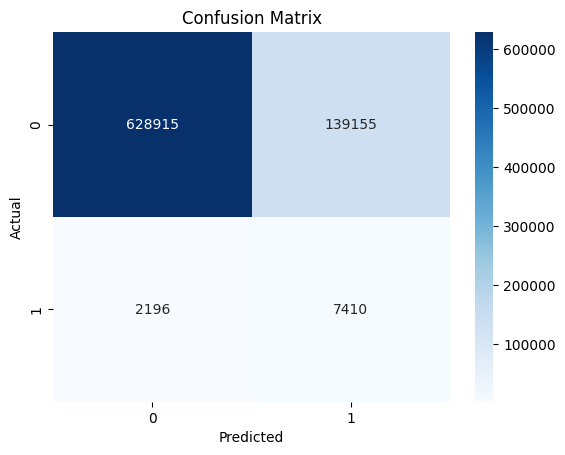

In [93]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [94]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    768070
           1       0.05      0.77      0.09      9606

    accuracy                           0.82    777676
   macro avg       0.52      0.80      0.50    777676
weighted avg       0.98      0.82      0.89    777676



### SVM on 10 years

In [35]:
results = []
rus = RandomUnderSampler(random_state=1234)

for year in tqdm(range(2014, 2024), desc="Processing years"):
    train = contracts[contracts['YEAR'] == year]
    test = contracts[contracts['YEAR'] == year + 1]

    X_train = train.drop(['YEAR', 'DAMAGE'], axis=1)
    y_train = train['DAMAGE']
    X_test = test.drop(['YEAR', 'DAMAGE'], axis=1)
    y_test = test['DAMAGE']

    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    numerical = X_rus.select_dtypes(include=['int64', 'float64']).columns
    categorical = X_rus.select_dtypes(include=['object']).columns
    X_rus[categorical] = X_rus[categorical].astype(str)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
        ])

    SVMmodel = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='rbf', C=0.3, gamma=0.3, random_state=1234))
    ])

    SVMmodel.fit(X_rus, y_rus)
    y_pred = SVMmodel.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
    results.append({'year': year, 'accuracy':accuracy, 'recall':recall, 'precision':precision})

results_df = pd.DataFrame(results)

Processing years: 100%|██████████| 10/10 [1:44:57<00:00, 629.70s/it]


In [38]:
# Transform dataframe to long format
results_df_long = results_df.melt(id_vars='year', value_vars=['accuracy', 'recall', 'precision'],
                                  var_name='metric', value_name='value')

In [42]:
# Plot results
fig = px.line(results_df_long, x='year', y='value', color='metric', 
              title='Yearly SVM Model Performance')

fig.update_layout(
    xaxis=dict(showgrid=False, linecolor='black'),
    yaxis=dict(showgrid=False, linecolor='black', zeroline= False),
    paper_bgcolor='white'
)

fig.show()

In [41]:
mean_metrics = results_df[['accuracy', 'recall', 'precision']].mean().reset_index()
mean_metrics.columns = ['Metric', 'Mean']
print(mean_metrics)

      Metric      Mean
0   accuracy  0.743626
1     recall  0.808847
2  precision  0.043977


### Probabilities

In order to run this section, you have to run the model with the option `probabilities = True`. This is a very consuming model and it might take several hours to run.

In [75]:
# Predict probabilities
y_pred_proba = SVMmodel.predict_proba(X_test)[:, 1]

In [78]:
# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8204988383070058


In [50]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create a DataFrame for Plotly
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Plot ROC curve
fig = px.area(
    roc_data, 
    x='False Positive Rate', 
    y='True Positive Rate', 
    title=f'ROC Curve KNN (AUC = {auc:.2f})',
    width=700, 
    height=500
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, linecolor='black'),
    paper_bgcolor='white'
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.show()

### Decision function

In [80]:
# Use the decision function on the test set
decision_scores = SVMmodel.decision_function(X_test)

print('Decision Scores:')
print(decision_scores[:5])

Decision Scores:
[-1.11842288 -0.99969085  0.99753202 -1.00002831 -1.00011586]


In [83]:
# Create a DataFrame for visualization
decision_scores_df = pd.DataFrame({
    'Decision Score': decision_scores,
    'True Label': y_test
})

# Filter the DataFrame to include only rows where True Label is 1
decision_scores_1 = decision_scores_df[decision_scores_df['True Label'] == 1]

# Visualize the decision scores
fig = px.scatter(decision_scores_df, x=decision_scores_df.index, y='Decision Score', color='True Label', 
                 title='Decision Scores of SVM Model',
                 labels={'index': 'Sample Index'})

fig.show()